# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


c:\source\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [4]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [5]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [6]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [7]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [8]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [9]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 12.0 Training loss: 1.0610 Explore P: 0.9988
Episode: 2 Total reward: 25.0 Training loss: 1.1419 Explore P: 0.9963
Episode: 3 Total reward: 19.0 Training loss: 1.1054 Explore P: 0.9945
Episode: 4 Total reward: 27.0 Training loss: 1.2769 Explore P: 0.9918
Episode: 5 Total reward: 11.0 Training loss: 1.1895 Explore P: 0.9907
Episode: 6 Total reward: 12.0 Training loss: 1.1120 Explore P: 0.9896
Episode: 7 Total reward: 22.0 Training loss: 1.1449 Explore P: 0.9874
Episode: 8 Total reward: 21.0 Training loss: 1.1333 Explore P: 0.9854
Episode: 9 Total reward: 13.0 Training loss: 1.1437 Explore P: 0.9841
Episode: 10 Total reward: 17.0 Training loss: 1.2406 Explore P: 0.9824
Episode: 11 Total reward: 12.0 Training loss: 1.2189 Explore P: 0.9813
Episode: 12 Total reward: 30.0 Training loss: 1.0029 Explore P: 0.9784
Episode: 13 Total reward: 10.0 Training loss: 1.2622 Explore P: 0.9774
Episode: 14 Total reward: 35.0 Training loss: 1.1709 Explore P: 0.9740
Episode: 15 Tot

Episode: 118 Total reward: 52.0 Training loss: 17.2870 Explore P: 0.7769
Episode: 119 Total reward: 13.0 Training loss: 19.7475 Explore P: 0.7759
Episode: 120 Total reward: 21.0 Training loss: 22.7705 Explore P: 0.7743
Episode: 121 Total reward: 12.0 Training loss: 208.4954 Explore P: 0.7734
Episode: 122 Total reward: 20.0 Training loss: 17.9277 Explore P: 0.7719
Episode: 123 Total reward: 22.0 Training loss: 15.8066 Explore P: 0.7702
Episode: 124 Total reward: 14.0 Training loss: 306.5773 Explore P: 0.7692
Episode: 125 Total reward: 11.0 Training loss: 14.0566 Explore P: 0.7683
Episode: 126 Total reward: 42.0 Training loss: 429.9567 Explore P: 0.7651
Episode: 127 Total reward: 16.0 Training loss: 237.3074 Explore P: 0.7639
Episode: 128 Total reward: 17.0 Training loss: 13.7298 Explore P: 0.7627
Episode: 129 Total reward: 18.0 Training loss: 16.8066 Explore P: 0.7613
Episode: 130 Total reward: 12.0 Training loss: 400.2747 Explore P: 0.7604
Episode: 131 Total reward: 17.0 Training loss:

Episode: 232 Total reward: 11.0 Training loss: 68.2825 Explore P: 0.6475
Episode: 233 Total reward: 9.0 Training loss: 3.1763 Explore P: 0.6469
Episode: 234 Total reward: 8.0 Training loss: 66.5695 Explore P: 0.6464
Episode: 235 Total reward: 16.0 Training loss: 65.9060 Explore P: 0.6454
Episode: 236 Total reward: 15.0 Training loss: 3.1322 Explore P: 0.6444
Episode: 237 Total reward: 9.0 Training loss: 176.5467 Explore P: 0.6438
Episode: 238 Total reward: 15.0 Training loss: 58.6475 Explore P: 0.6429
Episode: 239 Total reward: 21.0 Training loss: 2.9264 Explore P: 0.6416
Episode: 240 Total reward: 10.0 Training loss: 76.7126 Explore P: 0.6409
Episode: 241 Total reward: 12.0 Training loss: 3.1767 Explore P: 0.6402
Episode: 242 Total reward: 14.0 Training loss: 106.6991 Explore P: 0.6393
Episode: 243 Total reward: 13.0 Training loss: 132.2572 Explore P: 0.6385
Episode: 244 Total reward: 13.0 Training loss: 217.6221 Explore P: 0.6377
Episode: 245 Total reward: 17.0 Training loss: 4.4641 

Episode: 353 Total reward: 26.0 Training loss: 24.4922 Explore P: 0.5418
Episode: 354 Total reward: 19.0 Training loss: 148.2108 Explore P: 0.5408
Episode: 355 Total reward: 16.0 Training loss: 82.1515 Explore P: 0.5400
Episode: 356 Total reward: 18.0 Training loss: 106.0623 Explore P: 0.5390
Episode: 357 Total reward: 9.0 Training loss: 24.7600 Explore P: 0.5385
Episode: 358 Total reward: 19.0 Training loss: 84.6389 Explore P: 0.5375
Episode: 359 Total reward: 14.0 Training loss: 56.8564 Explore P: 0.5368
Episode: 360 Total reward: 22.0 Training loss: 1.7649 Explore P: 0.5356
Episode: 361 Total reward: 19.0 Training loss: 1.0606 Explore P: 0.5346
Episode: 362 Total reward: 20.0 Training loss: 26.1265 Explore P: 0.5336
Episode: 363 Total reward: 10.0 Training loss: 45.3970 Explore P: 0.5331
Episode: 364 Total reward: 30.0 Training loss: 123.2494 Explore P: 0.5315
Episode: 365 Total reward: 10.0 Training loss: 44.5185 Explore P: 0.5310
Episode: 366 Total reward: 12.0 Training loss: 20.9

Episode: 471 Total reward: 13.0 Training loss: 0.7937 Explore P: 0.4371
Episode: 472 Total reward: 16.0 Training loss: 31.0715 Explore P: 0.4364
Episode: 473 Total reward: 15.0 Training loss: 1.1187 Explore P: 0.4358
Episode: 474 Total reward: 21.0 Training loss: 19.1636 Explore P: 0.4349
Episode: 475 Total reward: 9.0 Training loss: 2.0600 Explore P: 0.4345
Episode: 476 Total reward: 14.0 Training loss: 32.7034 Explore P: 0.4339
Episode: 477 Total reward: 16.0 Training loss: 1.4567 Explore P: 0.4332
Episode: 478 Total reward: 20.0 Training loss: 1.1738 Explore P: 0.4324
Episode: 479 Total reward: 13.0 Training loss: 0.8794 Explore P: 0.4318
Episode: 480 Total reward: 13.0 Training loss: 42.8750 Explore P: 0.4313
Episode: 481 Total reward: 20.0 Training loss: 14.0480 Explore P: 0.4304
Episode: 482 Total reward: 13.0 Training loss: 1.7519 Explore P: 0.4299
Episode: 483 Total reward: 15.0 Training loss: 2.1924 Explore P: 0.4293
Episode: 484 Total reward: 39.0 Training loss: 25.3683 Explo

Episode: 586 Total reward: 59.0 Training loss: 18.0579 Explore P: 0.2701
Episode: 587 Total reward: 76.0 Training loss: 44.7758 Explore P: 0.2681
Episode: 588 Total reward: 100.0 Training loss: 2.5540 Explore P: 0.2656
Episode: 590 Total reward: 70.0 Training loss: 1.9816 Explore P: 0.2588
Episode: 591 Total reward: 140.0 Training loss: 30.4202 Explore P: 0.2553
Episode: 592 Total reward: 73.0 Training loss: 38.2857 Explore P: 0.2535
Episode: 593 Total reward: 82.0 Training loss: 2.0153 Explore P: 0.2515
Episode: 594 Total reward: 60.0 Training loss: 28.9648 Explore P: 0.2501
Episode: 595 Total reward: 51.0 Training loss: 55.0449 Explore P: 0.2489
Episode: 596 Total reward: 76.0 Training loss: 90.0289 Explore P: 0.2471
Episode: 597 Total reward: 48.0 Training loss: 95.7758 Explore P: 0.2459
Episode: 598 Total reward: 47.0 Training loss: 42.1864 Explore P: 0.2448
Episode: 599 Total reward: 103.0 Training loss: 49.2993 Explore P: 0.2424
Episode: 600 Total reward: 94.0 Training loss: 1.84

Episode: 701 Total reward: 101.0 Training loss: 1.7124 Explore P: 0.1437
Episode: 702 Total reward: 69.0 Training loss: 84.1651 Explore P: 0.1428
Episode: 703 Total reward: 119.0 Training loss: 103.1424 Explore P: 0.1413
Episode: 704 Total reward: 169.0 Training loss: 1.1077 Explore P: 0.1391
Episode: 706 Total reward: 61.0 Training loss: 1.4392 Explore P: 0.1357
Episode: 707 Total reward: 70.0 Training loss: 78.6227 Explore P: 0.1348
Episode: 709 Total reward: 14.0 Training loss: 85.4543 Explore P: 0.1322
Episode: 711 Total reward: 12.0 Training loss: 2.0378 Explore P: 0.1296
Episode: 714 Total reward: 99.0 Training loss: 0.7876 Explore P: 0.1238
Episode: 715 Total reward: 109.0 Training loss: 0.6592 Explore P: 0.1226
Episode: 716 Total reward: 99.0 Training loss: 0.9608 Explore P: 0.1215
Episode: 717 Total reward: 69.0 Training loss: 1.1686 Explore P: 0.1207
Episode: 718 Total reward: 116.0 Training loss: 89.9526 Explore P: 0.1194
Episode: 720 Total reward: 138.0 Training loss: 0.729

Episode: 900 Total reward: 95.0 Training loss: 21.3438 Explore P: 0.0202
Episode: 901 Total reward: 126.0 Training loss: 0.7171 Explore P: 0.0201
Episode: 902 Total reward: 87.0 Training loss: 347.1349 Explore P: 0.0200
Episode: 903 Total reward: 106.0 Training loss: 0.3315 Explore P: 0.0199
Episode: 905 Total reward: 194.0 Training loss: 0.2319 Explore P: 0.0195
Episode: 907 Total reward: 102.0 Training loss: 0.3538 Explore P: 0.0192
Episode: 909 Total reward: 33.0 Training loss: 80.9575 Explore P: 0.0190
Episode: 911 Total reward: 65.0 Training loss: 0.1696 Explore P: 0.0188
Episode: 913 Total reward: 72.0 Training loss: 0.2048 Explore P: 0.0185
Episode: 915 Total reward: 70.0 Training loss: 0.1284 Explore P: 0.0183
Episode: 917 Total reward: 101.0 Training loss: 0.2432 Explore P: 0.0181
Episode: 919 Total reward: 57.0 Training loss: 0.2606 Explore P: 0.0179
Episode: 921 Total reward: 73.0 Training loss: 104.0710 Explore P: 0.0176
Episode: 923 Total reward: 62.0 Training loss: 0.3152

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

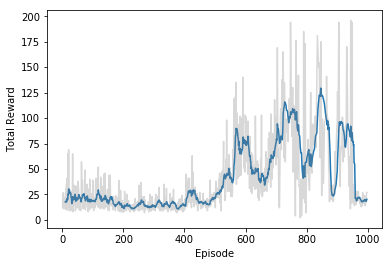

In [11]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.